# cmi_nd_ggg()

## Imports

In [1]:
import time
from itertools import product
import cupy as cp
import numpy as np
import frites
import xfrites
import scipy as sp
from cupyx.scipy.special import digamma as psi
# from mne.utils import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

print(f"Cupy : {cp.__version__}")
print(f"Numpy : {np.__version__}")
print(f"Frites : {frites.__version__}")
print(f"Xfrites : {xfrites.__version__}")

## CPU function

In [1]:
def cpu_cmi_nd_ggg(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
                   demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = np.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = np.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = np.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = np.linalg.cholesky(cz)
    chcxz = np.linalg.cholesky(cxz)
    chcyz = np.linalg.cholesky(cyz)
    chcxyz = np.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = np.log(np.einsum('...ii->...i', chcz)).sum(-1)
    hxz = np.log(np.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = np.log(np.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = np.log(np.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = np.log(2)
    if biascorrect:
        vec = np.arange(1, nvarxyz + 1)
        psiterms = sp.special.psi((ntrl - vec).astype(np.float) / 2.0) / 2.0
        dterm = (ln2 - np.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

## GPU function

In [1]:
def gpu_cmi_nd_ggg(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
                   demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = cp.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = cp.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = cp.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = cp.linalg.cholesky(cz)
    chcxz = cp.linalg.cholesky(cxz)
    chcyz = cp.linalg.cholesky(cyz)
    chcxyz = cp.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = cp.log(cp.einsum('...ii->...i', chcz)).sum(-1)
    hxz = cp.log(cp.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = cp.log(cp.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = cp.log(cp.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = cp.log(2)
    if biascorrect:
        vec = cp.arange(1, nvarxyz + 1)
        psiterms = psi((ntrl - vec).astype(np.float) / 2.0) / 2.0
        dterm = (ln2 - np.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

## Testing

In [1]:
# n_epochs = np.arange(2000, 30001, 2000)
# nt_points = np.arange(500, 2001, 500)

n_trials = np.arange(500, 1001, 100)
n_conds = np.arange(10, 51, 10)

n_params = (300,)

pairs = product(n_trials, n_conds)

cpu_vals, gpu_vals = np.array([]), cp.array([])
cpu_times, gpu_times = [], []
for p in pairs:
  nt = p[0]
  nm = p[1]
  
  dims = n_params + (nm, nt,)
  
  cx = np.random.uniform(-10, 10, dims)
  cy = np.random.uniform(-10, 10, dims)
  cz = np.random.uniform(-10, 10, dims)

  gx = cp.asarray(cx)
  gy = cp.asarray(cy)
  gz = cp.asarray(cz)
  
#   pbar = ProgressBar(range(ntp), mesg="CPU implementation")
  start = time.time()
  cpu_i = cpu_cmi_nd_ggg(cx, cy, cz, mvaxis=-2, traxis=-1, biascorrect=True,
                         shape_checking=False)
#   pbar.update_with_increment_value(1)
  cpu_vals = np.hstack((cpu_vals, cpu_i.mean()))
  stop = time.time()
  print('cpu', (stop - start))
  cpu_times.append(stop - start)
    
#   pbar = ProgressBar(range(ntp), mesg="GPU implementation")
  start = time.time()  
  gpu_i = gpu_cmi_nd_ggg(gx, gy, gz, mvaxis=-2, traxis=-1, biascorrect=True,
                         shape_checking=False)
#   pbar.update_with_increment_value(1)
  gpu_vals = cp.hstack((gpu_vals, gpu_i.mean()))
  stop = time.time()
  print('gpu', (stop - start))
  gpu_times.append(stop - start)
    
  np.testing.assert_allclose(gpu_vals.get(), cpu_vals, rtol=1e-5)
  print(p, 'done')

## Plot results

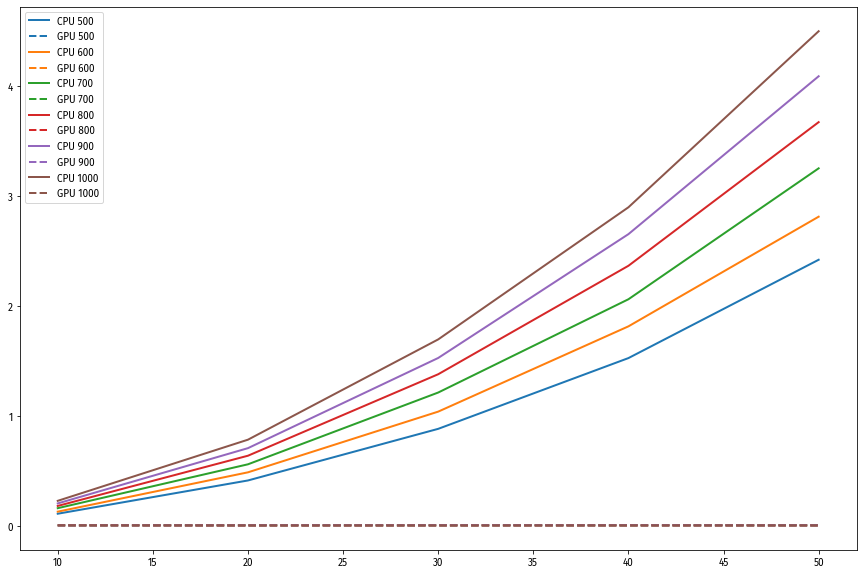

[]

In [1]:
%matplotlib inline

array_cpu_times = np.array(cpu_times).reshape(len(n_trials), len(n_conds))
array_gpu_times = np.array(gpu_times).reshape(len(n_trials), len(n_conds))

fig = plt.figure(figsize=(15, 10))
for i in range(len(n_trials)):
  color = 'C{0}'.format(i)
  plt.plot(n_conds, array_cpu_times[i, :], color=color, linestyle='-', 
           linewidth=2, label='CPU {0}'.format(n_trials[i]))
  plt.plot(n_conds, array_gpu_times[i, :], color=color, linestyle='--', 
           linewidth=2, label='GPU {0}'.format(n_trials[i]))

plt.legend()

plt.plot()
